In [272]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
from pyLDAvis import gensim_models 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import os
import sys
import ast
from textblob import TextBlob
from nrclex import NRCLex

import string
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime



In [273]:
# nltk.download('stopwords')

In [274]:
five_g_data = pd.read_csv('5g_dataset.csv', sep=',', index_col= None) \
    .drop(columns='Unnamed: 0')

# five_g_data
#.sample(2)

In [275]:
# Extract exact dates

old_dates = five_g_data['created']

date_time = [datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S') for date in old_dates]

date = pd.to_datetime(date_time)

five_g_data['date'] = date.date
five_g_data = five_g_data.drop(columns='created').drop_duplicates()
# organic_food_reddit.sample(2)

In [276]:
x = five_g_data['subreddit'].unique().tolist()
len(x)

110

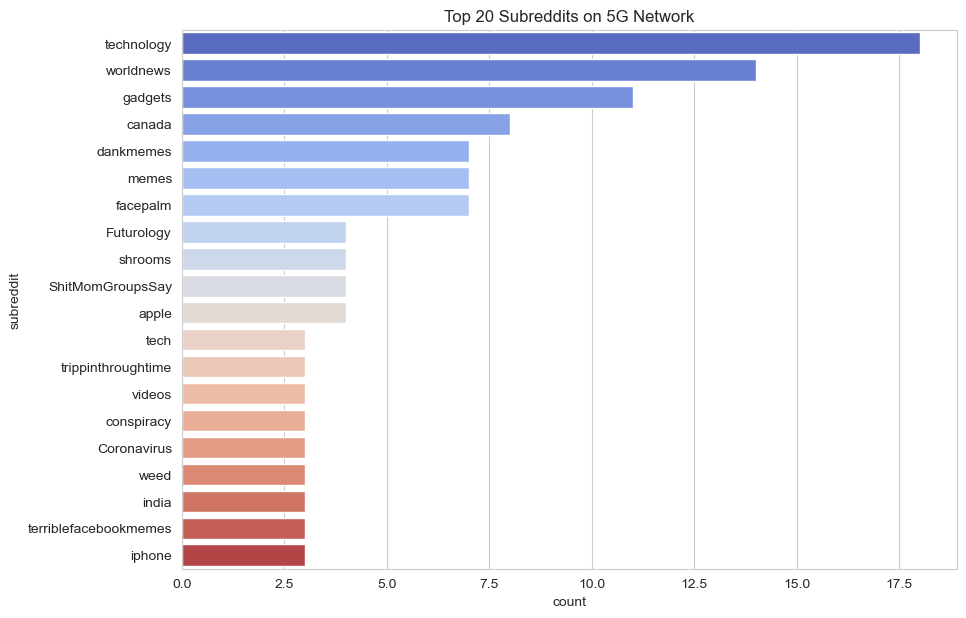

In [277]:
# Subreddits Descriptive Stats
sns.set_style('whitegrid')
subreddits = five_g_data['subreddit'].value_counts().sort_values(ascending=False).head(20).reset_index()
subreddits.shape
plt.figure(figsize=(10,7))
plt.title("Top 20 Subreddits on 5G Network")
sns.barplot(subreddits, x='count', y='subreddit', errorbar='sd', palette='coolwarm')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


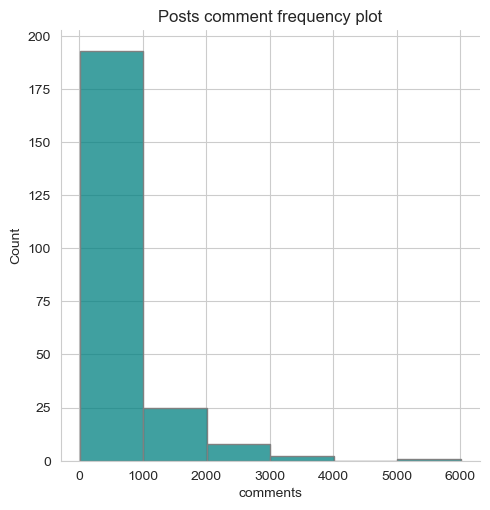

In [278]:
# Content comments / votes distribution

sns.displot(
    data=five_g_data, 
    x='comments', 
    binwidth = 1000, 
    color= 'teal', 
    edgecolor= 'gray')
plt.title('Posts comment frequency plot')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


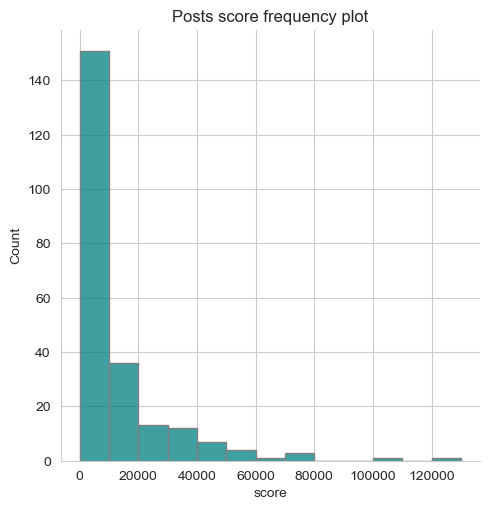

In [279]:
# Content score / votes distribution

sns.displot(
    data=five_g_data, 
    x='score', 
    binwidth = 10000, 
    color= 'teal', 
    edgecolor= 'gray')
plt.title('Posts score frequency plot')
plt.show()  

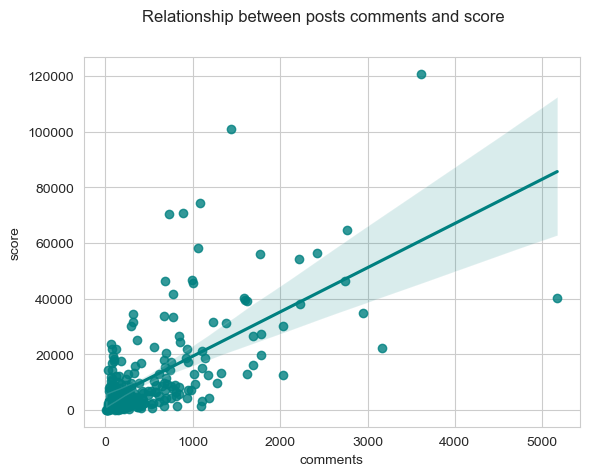

In [280]:
sns.set_style('whitegrid')
sns.regplot(five_g_data, x='comments', y='score', color='teal')
plt.suptitle('Relationship between posts comments and score')
plt.show()

In [281]:
# Handle words contractions

def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s" : " is",
        "'d" : " would",
        "'ve" : " have",
        "'re": " are",
        "'ll": " will",
        "'m": " am"
    }
    
    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)


In [282]:
# Preprocess text, remove stopwords, tokenize and Lemmatize

def preprocess_text(text, freq_words=False):
    text = re.sub(r"\d+", '', text)
    text = text.lower()
    
    ## remove numbers from the text
    text = re.sub(r"\d+", '', text)
    
    ## removing punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    ## Tokenize text
    tokens = word_tokenize(text)
    
    ## Remove stopwords
    stop_words = stopwords.words("english")
    if freq_words:
        stop_words.extend(['g','G','£', '“', '’', '”', '‘'])
    tokens = [token for token in tokens if token not in stop_words]
    ## Remove contractions from words
    text = handle_contractions(' '.join(tokens))
    
    ## Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    
    return ' '.join(tokens)


In [283]:
five_g_data = five_g_data.fillna("")

In [284]:
five_g_data['cleaned_title'] = five_g_data['title'].apply(preprocess_text)

In [285]:
# Calculate sentiments

def percentage(val, total):
    return (val / total) * 100

# Sentiment Scores
def get_sentiment_scores(text_array):
    
    positive = 0
    negative = 0
    neutral = 0

    scores = []

    content_list = []

    positive_list = []
    negative_list = []
    neutral_list = []

    contents = text_array
    
    subjectivity_score = contents.apply(lambda x: TextBlob(x).sentiment.subjectivity)
    polarity_score = contents.apply(lambda x: TextBlob(x).sentiment.polarity)

    for content in contents:
        #print(content)
        content_list.append(content)
        score = SentimentIntensityAnalyzer().polarity_scores(content)
        neg_score = score['neg']
        pos_score = score['pos']
        neu_score = score['neu']    
        
        scores.append([neg_score, pos_score, neu_score])
        
        if neg_score > pos_score:
            negative_list.append(content)
            negative += 1
        elif neg_score < pos_score:
            positive_list.append(content)
            positive += 1
        elif neg_score == pos_score:
            neutral_list.append(content)
            neutral += 1
            
    positive = percentage(positive, len(contents))
    negative = percentage(negative, len(contents))
    neutral = percentage(neutral, len(contents))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')
    
    
    return {
        'polarity': polarity_score,
        'subjectivity': subjectivity_score,
        'scores': scores,
        'positive': positive,
        'negative': negative,
        'neutral' : neutral
    }

In [286]:
# get sentiment scores
all_scores = get_sentiment_scores(five_g_data['cleaned_title'])

# add sentiment scores to dataframe
five_g_data_scores = five_g_data.reset_index()\
    .merge(pd.DataFrame(all_scores['scores'], columns=["neg", "pos", "neu"]).reset_index())

# add polarity and subjectivity scores to dataframe
five_g_data_scores['polarity'] = all_scores['polarity']
five_g_data_scores['subjectivity'] = all_scores['subjectivity']

# percentages of positive, negative and neutral
positive = all_scores['positive']
negative = all_scores['negative']
neutral = all_scores['neutral']

# attach sentiment scores
five_g_data_scores.loc[five_g_data_scores['neg'] > five_g_data_scores['pos'], "sentiment_label"] = "negative"
five_g_data_scores.loc[five_g_data_scores['pos'] > five_g_data_scores['neg'], "sentiment_label"] = "positive"
five_g_data_scores.loc[five_g_data_scores['neg'] == five_g_data_scores['pos'], "sentiment_label"] = "neutral"

five_g_data_scores.sample(2)

index                                              title        subreddit  \
95     95  5G Drains iPhone 12 Battery 20% Faster Than 4G...            apple   
59     59  I'm renaming my router to "5G VACCINE CHIP ACT...  HermanCainAward   

    score      id                                                url  \
95  13055  jfa72y  https://www.macrumors.com/2020/10/21/iphone-12...   
59  12961  tdmdbe                https://i.redd.it/clbprp71a9n81.jpg   

    comments body        date  \
95      1010       2020-10-21   
59       614       2022-03-14   

                                        cleaned_title  neg  pos  neu  \
95          g drain iphone battery faster g benchmark  0.0  0.0  1.0   
59  im renaming router g vaccine chip activator right  0.0  0.0  1.0   

    polarity  subjectivity sentiment_label  
95  0.000000      0.000000         neutral  
59  0.285714      0.535714         neutral

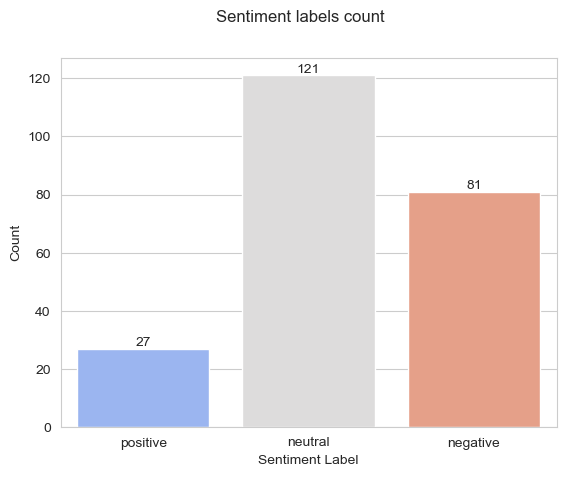

In [287]:
# sentiment labels barplot

plt.suptitle('Sentiment labels count')
sns.set_style('whitegrid')
ax = sns.countplot(data=five_g_data_scores, x="sentiment_label", palette='coolwarm', order=['positive', 'neutral', 'negative'])
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [288]:
# five_g_data[five_g_data["score"]]
# neg_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "negative"]
cv = [date.year for date in five_g_data_scores['date']]

five_g_data_scores['year'] = cv



In [289]:
neg_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "negative"]
pos_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "positive"]
neu_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "neutral"]

neg_five_g = neg_five_g[['year','sentiment_label']].groupby("year").count()
pos_five_g = pos_five_g[['year','sentiment_label']].groupby("year").count()
# neu_five_g = neu_five_g[['year','sentiment_label']].groupby("year").count()

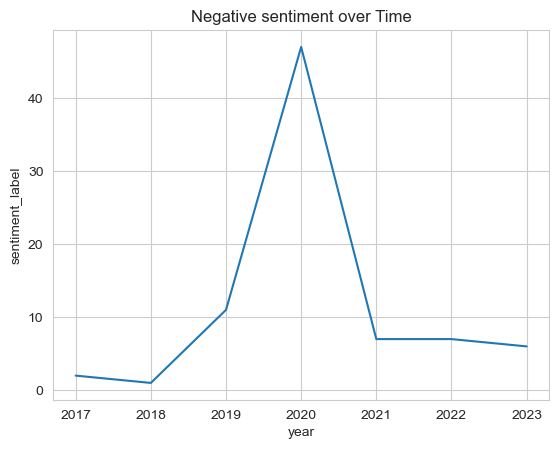

In [290]:
plt.title("Negative sentiment over Time")
sns.lineplot(
    data=neg_five_g,
    x="year", y="sentiment_label",
    markers=True, dashes=False
)
plt.show()

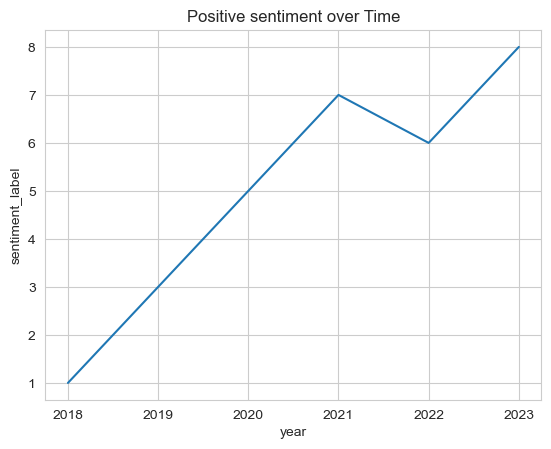

In [291]:
plt.title("Positive sentiment over Time")
sns.lineplot(
    data=pos_five_g,
    x="year", y="sentiment_label",
    markers=True, dashes=False
)
plt.show()

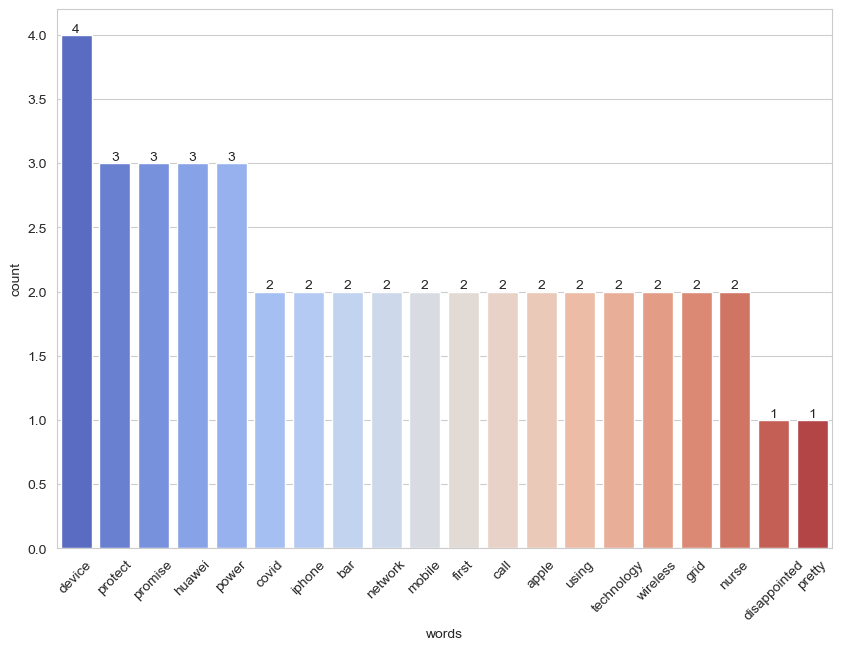

In [292]:

# word frequency for positive sentiments

positive_df = five_g_data_scores.loc[five_g_data_scores['sentiment_label'] == 'positive']['cleaned_title']
positive_words = " ".join(positive_df.apply(preprocess_text, freq_words = True))
words_count = Counter(positive_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

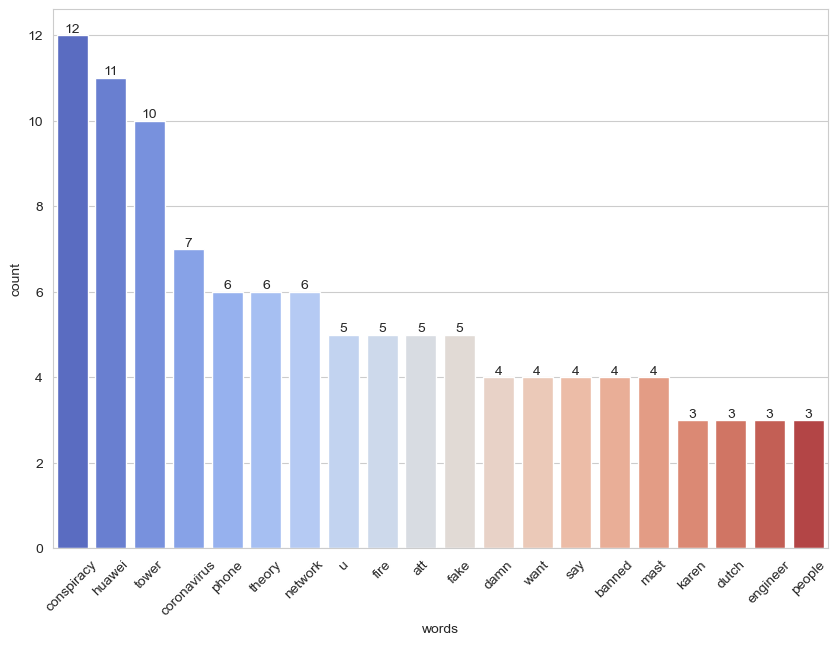

In [293]:
negative_df = five_g_data_scores.loc[five_g_data_scores['sentiment_label'] == 'negative']['cleaned_title']
negative_words = " ".join(negative_df.apply(preprocess_text, freq_words = True))
words_count = Counter(negative_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


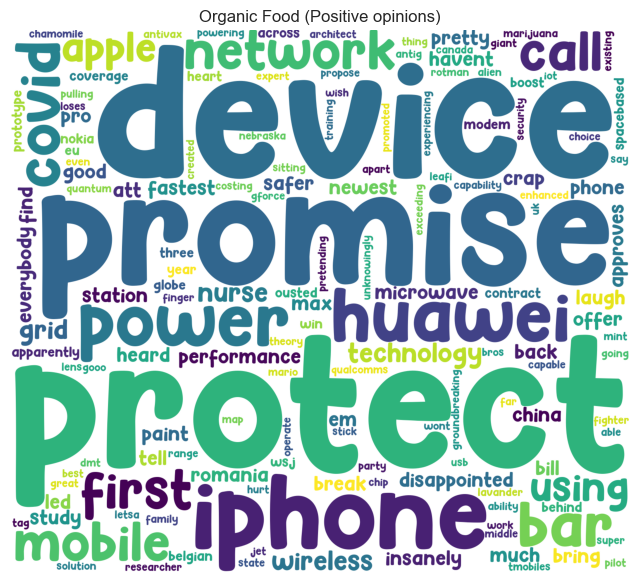

In [294]:
wordcloud_positive = WordCloud(
    background_color='white',
    max_words=150,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(positive_words)

plt.figure(figsize=(8,16))
plt.imshow(wordcloud_positive)
plt.title("Organic Food (Positive opinions)")
plt.axis('off')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


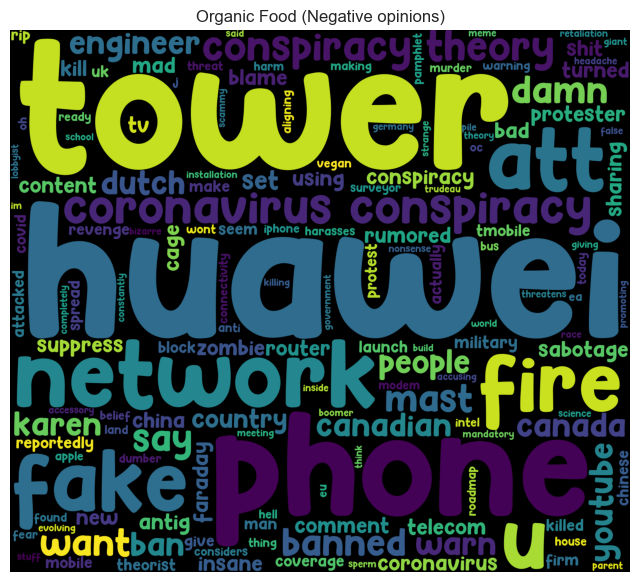

In [295]:
wordcloud_negative = WordCloud(
    background_color='black',
    max_words=150,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(negative_words)

plt.figure(figsize=(8,16))
plt.imshow(wordcloud_negative)
plt.title("Organic Food (Negative opinions)")
plt.axis('off')
plt.show()

In [296]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(five_g_data['cleaned_title'])
# Perform K-means clustering
num_clusters = 4 # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
# Assign cluster labels to the feedback data
five_g_data['Cluster'] = kmeans.labels_
# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=five_g_data['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()
# Print the top terms for each cluster

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [297]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print()

Top terms per cluster:
Cluster 0:
 tower
 phone
 baby
 turn
 sabotage
 protester
 att
 dutch
 cause
 coronavirus

Cluster 1:
 conspiracy
 coronavirus
 going
 theory
 youtube
 content
 suppress
 tower
 vegan
 belief

Cluster 2:
 huawei
 network
 say
 damn
 know
 canada
 got
 antig
 get
 internet

Cluster 3:
 covid
 indian
 point
 government
 also
 india
 cause
 say
 network
 nurse



In [298]:
# Bag of words model

# create dictionary
five_g_data_scores['cleaned_title_list'] = [list(sent.split()) for sent in five_g_data_scores['cleaned_title'].apply(preprocess_text, freq_words = True)]
id2word = gensim.corpora.Dictionary(five_g_data_scores['cleaned_title_list'])

corpus = [id2word.doc2bow(text) for text in five_g_data_scores['cleaned_title_list']]

In [299]:
# Using coherence model to determine the number of topics

num_topics = []
coherence_score = []

text = five_g_data_scores['cleaned_title_list']

for i in range(1, 10):
    lda_model = LdaModel(corpus=corpus, id2word = id2word, iterations = 50, num_topics = i)
    coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    num_topics.append(i)
    coherence_score.append(coherence_lda)
    
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics': num_topics,
                                'coherence_score': coherence_score})

sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')
plt.show()

In [304]:
# Topic modelling with LDA

# number of topics
n_topics = 4

lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word, 
    num_topics=n_topics, 
    random_state=100, 
    update_every=1, 
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} Word: {topic}")


Topic: 0 Word: 0.027*"coronavirus" + 0.025*"conspiracy" + 0.024*"theory" + 0.022*"tower" + 0.020*"mast" + 0.015*"say" + 0.014*"fire" + 0.012*"antig" + 0.012*"covid" + 0.011*"necklace"
Topic: 1 Word: 0.049*"huawei" + 0.046*"network" + 0.017*"canadian" + 0.015*"country" + 0.014*"banned" + 0.013*"canada" + 0.012*"new" + 0.012*"reportedly" + 0.012*"security" + 0.012*"plan"
Topic: 2 Word: 0.028*"phone" + 0.016*"launch" + 0.013*"people" + 0.011*"att" + 0.011*"dont" + 0.011*"fake" + 0.011*"nebraska" + 0.011*"tmobiles" + 0.010*"coverage" + 0.010*"mobile"
Topic: 3 Word: 0.040*"u" + 0.019*"could" + 0.018*"set" + 0.016*"iphone" + 0.015*"device" + 0.014*"apple" + 0.014*"th" + 0.013*"using" + 0.012*"warns" + 0.011*"hurt"


In [305]:
# Visualize with pyLDAvis

pyLDAvis.enable_notebook()

vis = gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.183555  0.063106       1        1  28.633094
1      0.137242  0.131119       2        1  25.614815
3      0.051748 -0.130584       3        1  24.968369
2     -0.005435 -0.063641       4        1  20.783722, topic_info=            Term       Freq      Total Category  logprob  loglift
87        huawei  14.000000  14.000000  Default  30.0000  30.0000
34       network  14.000000  14.000000  Default  29.0000  29.0000
2              u  11.000000  11.000000  Default  28.0000  28.0000
79         phone   7.000000   7.000000  Default  27.0000  27.0000
193  coronavirus   9.000000   9.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
708     physical   1.849463   2.380209   Topic4  -4.8599   1.3187
694   autentiskt   1.828751   2.387078   Topic4  -4.8711   1.3046
315         dont   2.624752   3.429467   Topic4  -4.5098   1.3036
695         från   1.828751   2.387078   Topic4  -4.8711   1.3046
212       mobile   2.288913   3.267197   Topic4  -4.6467   1.2151

[166 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
712       1  0.975936     ajit
701       2  0.859438   allows
722       2  0.324589     ally
722       3  0.649179     ally
399       4  0.736938  android
...     ...       ...      ...
91        2  0.890556     want
518       3  0.765428    warns
684       3  0.926087   washer
151       3  1.021688    watch
294       4  0.887395     year

[144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

#### Topic 0: Conspiracy Theories and 5G
**Key Words: "network", "tower", "coronavirus", "conspiracy", "theory", "covid"**

Interpretation: This topic seems to revolve around conspiracy theories related to 5G technology and its alleged connection to the spread of the coronavirus (COVID-19). It's well-known that there have been unfounded claims associating 5G networks with health issues and the pandemic, which is addressed in this topic.


#### Topic 1: Technology and 5G Devices
**Key Words: "mast", "could", "set", "fire", "device", "attacked"**

Interpretation: This topic appears to discuss the technological aspects of 5G, including network infrastructure ("mast"), potential issues ("fire"), and the security or vulnerabilities of 5G devices. The word "attacked" may suggest discussions on potential cybersecurity threats to 5G networks.


#### Topic 2: 5G and Technology Companies
**Key Words: "huawei", "phone", "canadian", "country", "canada", "banned"**

Interpretation: This topic is likely related to the involvement of technology companies in 5G deployment. "Huawei" is a prominent telecommunications equipment manufacturer, and discussions about its role in supplying 5G infrastructure are included. "Banned" suggests the controversy surrounding the use of Huawei's technology in certain countries, such as Canada.


#### Topic 3: 5G and Mobile Devices
**Key Words: "u," "iphone," "launch," "apple," "th"**

Interpretation: This topic appears to be about the launch of 5G-capable mobile devices, with specific reference to Apple's iPhone. It may discuss the rollout of 5G technology in mobile devices and the impact on the consumer market.

In [302]:
for topic_id in range(lda_model.num_topics):
    term_freqs = lda_model.get_topic_terms(topic_id)
    topic_size = len(lda_model.get_topic_terms(topic_id))
    print(f"Topic {topic_id}: Term Frequency - {term_freqs}, Topic Size - {topic_size}")

Topic 0: Term Frequency - [(135, 0.036965456), (133, 0.032205388), (225, 0.031637374), (216, 0.027518138), (612, 0.024708392), (212, 0.023599954), (234, 0.0231266), (721, 0.020604631), (720, 0.020604631), (215, 0.019820308)], Topic Size - 10
Topic 1: Term Frequency - [(351, 0.027580714), (411, 0.027207894), (345, 0.026308557), (315, 0.020947516), (142, 0.01830625), (371, 0.017801601), (116, 0.017090447), (342, 0.015498706), (555, 0.015466823), (689, 0.013311446)], Topic Size - 10
Topic 2: Term Frequency - [(87, 0.09115205), (318, 0.031843875), (319, 0.028108938), (249, 0.025606122), (168, 0.024665274), (321, 0.022220071), (594, 0.021921804), (536, 0.019928472), (158, 0.01690323), (246, 0.016535958)], Topic Size - 10
Topic 3: Term Frequency - [(34, 0.1027553), (36, 0.03552032), (30, 0.02708209), (27, 0.024946388), (552, 0.023763238), (379, 0.023217853), (165, 0.019072661), (593, 0.018822098), (726, 0.018287744), (32, 0.011991407)], Topic Size - 10
Topic 4: Term Frequency - [(675, 0.0293

In [303]:
for doc_id, doc in enumerate(corpus):
    print(doc)
    topic_distribution = lda_model[doc]
    print(topic_distribution)
    max_topic, max_prob = max(topic_distribution, key=lambda x: x[1])
    print(f"Document {doc_id} is primarily associated with Topic {max_topic} with probability {max_prob}")

[(0, 1), (1, 1), (2, 1)]
([(0, 0.031348705), (1, 0.031348445), (2, 0.031348214), (3, 0.03134846), (4, 0.031348743), (5, 0.031348124), (6, 0.780561), (7, 0.031348385)], [(0, [6]), (1, [6]), (2, [6])], [(0, [(6, 0.99998325)]), (1, [(6, 0.98761445)]), (2, [(6, 0.9999979)])])


TypeError: '>' not supported between instances of 'tuple' and 'int'